Converted VOCs to ppb with Total AVOCs:
   2-2-4-trimethylpentane_amean  o-xylene_amean  1-3-5-trimethylbenzene_amean  \
0                           NaN      201.903123                    196.590781   
1                     82.445955      118.381440                    180.882089   
2                     81.649979      118.275010                    190.981373   
3                     75.137672       77.213752                    201.400943   
4                     74.111476      155.001187                    171.699586   

   n-octane_amean  toluene_amean  m-p-xylene_amean  benzene_amean  \
0      105.658217     694.971114        559.840584     577.556631   
1      156.680463     518.347538        313.444481     439.988764   
2      146.383855     477.485835        315.497803     463.603311   
3       99.944396     336.382519        209.508982     393.827242   
4       77.019294     246.526421        572.059280     442.324436   

   1-2-3-trimethylbenzene_amean  ethylbenzene_amean  n-hep

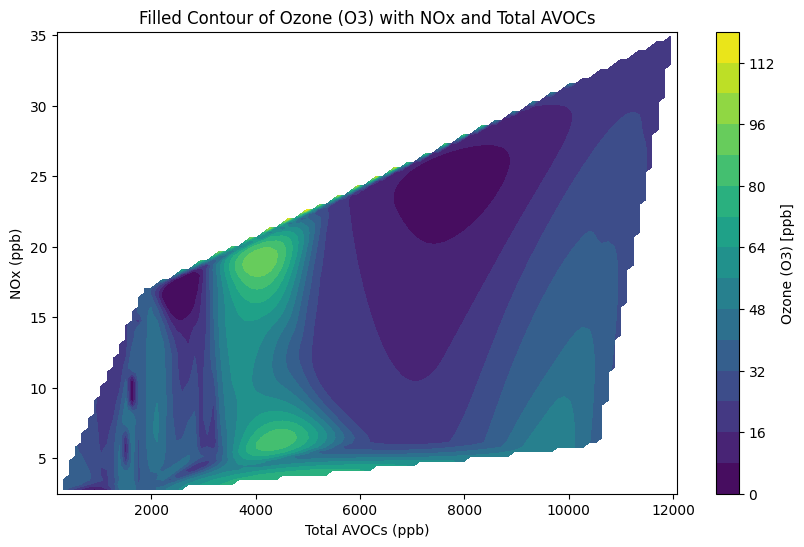

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Define the file path for VOC data
voc_file_path = r'/Users/jayarajupakki/Documents/Phd/Project_PAH/Data/VOC_data.xlsx'

# Load the VOC data from the Excel file
df_voc = pd.read_excel(voc_file_path)

# Define the molecular weights (g/mol)
molecular_weights = {
    "ethylbenzene": 106.17,
    "isoprene": 68.10,
    "2-2-4-trimethylpentane": 100.17,
    "1-2-3-trimethylbenzene": 120.18,
    "1-3-5-trimethylbenzene": 120.18,
    "n-heptane": 100.20,
    "m-p-xylene": 106.17,
    "toluene": 92.14,
    "n-octane": 114.22,
    "o-xylene": 106.17,
    "benzene": 78.11,
    "1-2-4-trimethylbenzene": 120.18
}

# List of VOC columns
voc_columns = ['2-2-4-trimethylpentane_amean', 'o-xylene_amean',
               '1-3-5-trimethylbenzene_amean', 'n-octane_amean',
               'toluene_amean', 'm-p-xylene_amean', 'benzene_amean',
               '1-2-3-trimethylbenzene_amean', 'ethylbenzene_amean',
               'n-heptane_amean', '1-2-4-trimethylbenzene_amean']

# Check if VOC columns exist in the DataFrame
for col in voc_columns:
    if col not in df_voc.columns:
        print(f"Column '{col}' not found in the DataFrame.")

# Proceed only if all columns are present
if all(col in df_voc.columns for col in voc_columns):
    # Convert VOCs from pmol/mol to ppb
    for col in voc_columns:
        compound_name = col[:-6]  # Remove the '_amean' part
        if compound_name in molecular_weights:
            df_voc[col] = (df_voc[col] * molecular_weights[compound_name] / 1000) * 24.45

    # Calculate Total AVOCs and add as a new column
    df_voc['Total_Avocs'] = df_voc[voc_columns].sum(axis=1)

    # Print the converted VOCs and the Total AVOCs to verify
    print("Converted VOCs to ppb with Total AVOCs:")
    print(df_voc[voc_columns + ['Total_Avocs']].head())
else:
    print("Not all VOC columns are present in the DataFrame.")

# Load the Excel file with additional data
excel_file_path = r'/Users/jayarajupakki/Documents/Phd/Project_PAH/Data/SIRTA_long term_2015_Max Planck_complete_vf02.xlsx'
df_excel = pd.read_excel(excel_file_path, sheet_name='Database', skiprows=0)

# Process the Excel data
df_excel = df_excel.iloc[1:].reset_index(drop=True)
df_excel['date_column'] = pd.to_datetime(df_excel['Sampling date'], errors='coerce')

# Prepare date filtering
df_excel['date'] = df_excel['date_column'].dt.date

# Ensure the VOC data has a date column; adjust if needed
df_voc['date'] = pd.to_datetime(df_voc['time']).dt.date  # Ensure 'time' is the correct date column

# Merge data based on the 'date' column
df_merged = pd.merge(df_excel, df_voc, on='date', how='inner')

# Calculate NOx (NO + NO2) if those columns exist
if 'NO' in df_merged.columns and 'NO2' in df_merged.columns:
    df_merged['NOx'] = df_merged['NO'] + df_merged['NO2']
else:
    print("NO or NO2 column not found in the merged DataFrame.")

# Select relevant columns
df_merged = df_merged[['date', 'Total_Avocs', 'NOx', 'O3']]

# Print the merged data
print("Merged Data:")
print(df_merged.head())

# Check for negative Ozone values
if (df_merged['O3'] < 0).any():
    print("Negative Ozone values detected. Removing or handling them...")
    df_merged = df_merged[df_merged['O3'] >= 0]  # Remove negatives

# Create grid data for interpolation
grid_x, grid_y = np.mgrid[df_merged['Total_Avocs'].min():df_merged['Total_Avocs'].max():100j,
                           df_merged['NOx'].min():df_merged['NOx'].max():100j]

grid_z = griddata((df_merged['Total_Avocs'], df_merged['NOx']), df_merged['O3'], (grid_x, grid_y), method='cubic')

# Clip negative values after interpolation
grid_z = np.clip(grid_z, a_min=0, a_max=None)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(grid_x, grid_y, grid_z, levels=14, cmap='viridis')
plt.colorbar(label='Ozone (O3) [ppb]')
plt.xlabel('Total AVOCs (ppb)')
plt.ylabel('NOx (ppb)')
plt.title('Filled Contour of Ozone (O3) with NOx and Total AVOCs')
plt.show()


In [115]:
import pandas as pd

# Define file paths
excel_file_path = r'/Users/jayarajupakki/Documents/Phd/Project_PAH/Data/SIRTA_long term_2015_Max Planck_complete_vf02.xlsx'
voc_file_path = r'/Users/jayarajupakki/Documents/Phd/Project_PAH/Data/VOC_data.xlsx'

# Load the main Excel data
df_excel = pd.read_excel(excel_file_path, sheet_name='Database', skiprows=0)

# Process the Excel data
# Convert 'Sampling date' to datetime and create a date column
df_excel['date_column'] = pd.to_datetime(df_excel['Sampling date'], errors='coerce')
df_excel['date'] = df_excel['date_column'].dt.date

# Check and calculate NOx
if 'NO' in df_excel.columns and 'NO2' in df_excel.columns:
    df_excel['NOx'] = df_excel['NO'] + df_excel['NO2']
else:
    print("NO or NO2 column not found in the Excel DataFrame.")

# Check for Ozone column and filter DataFrame
if 'O3' in df_excel.columns:
    df_excel = df_excel[['date', 'NOx', 'O3']]
else:
    print("O3 column not found in the Excel DataFrame.")

# Drop rows with NaN values and show the DataFrame
df_excel = df_excel.dropna()
print("DataFrame with date, NOx, and Ozone:")
print(df_excel.head())

# Load the ASOA data
df_asoa = pd.read_excel(excel_file_path, sheet_name='p+g_SOA_markers', skiprows=[1])

# Define ASOA columns to sum
asoa_columns = [
    'DHOPA', 'PHTHALIC ACID', '2-NITROPHENOL', '4-NITROPHENOL', 
    '2-METHYL-4-NITROPHENOL', '4-NITROGUAIACOL', '5-NITROGUAIACOL', 
    '4-METHYL-5-NITROCATHECOL', '3-METHYL-6-NITROCATHECOL', 
    '3-METHYL-5-NITROCATHECOL'
]

# Check for missing ASOA columns
missing_columns = [col for col in asoa_columns if col not in df_asoa.columns]
if missing_columns:
    print(f"The following columns are missing from the ASOA DataFrame: {missing_columns}")
else:
    # Calculate Total_ASOA
    df_asoa['Total_ASOA'] = df_asoa[asoa_columns].sum(axis=1)
    print("DataFrame with Total ASOA:")
    print(df_asoa[[*asoa_columns, 'Total_ASOA']].head())

# Load VOC data
df_voc = pd.read_excel(voc_file_path)

# Add date column to ASOA data
df_asoa['date'] = pd.to_datetime(df_asoa['Sampling date'], errors='coerce').dt.date

# Ensure VOC data has a date column
df_voc['date'] = pd.to_datetime(df_voc['time'], errors='coerce').dt.date  # Adjust 'time' if necessary

# Merge ASOA and VOC data on 'date'
df_merged = pd.merge(df_asoa, df_voc, on='date', how='inner')

# Define molecular weights (g/mol)
molecular_weights = {
    "ethylbenzene": 106.17,
    "isoprene": 68.10,
    "2-2-4-trimethylpentane": 100.17,
    "1-2-3-trimethylbenzene": 120.18,
    "1-3-5-trimethylbenzene": 120.18,
    "n-heptane": 100.20,
    "m-p-xylene": 106.17,
    "toluene": 92.14,
    "n-octane": 114.22,
    "o-xylene": 106.17,
    "benzene": 78.11,
    "1-2-4-trimethylbenzene": 120.18
}

# List of VOC columns
voc_columns = [
    '2-2-4-trimethylpentane_amean', 'o-xylene_amean',
    '1-3-5-trimethylbenzene_amean', 'n-octane_amean',
    'toluene_amean', 'm-p-xylene_amean', 'benzene_amean',
    '1-2-3-trimethylbenzene_amean', 'ethylbenzene_amean',
    'n-heptane_amean', '1-2-4-trimethylbenzene_amean'
]

# Check for VOC columns in merged DataFrame
missing_voc_columns = [col for col in voc_columns if col not in df_merged.columns]
if missing_voc_columns:
    print(f"Column(s) not found in the merged DataFrame: {missing_voc_columns}")
else:
    # Convert VOCs from pmol/mol to ppb
    for col in voc_columns:
        compound_name = col[:-6]  # Remove '_amean'
        if compound_name in molecular_weights:
            df_merged[col] = (df_merged[col] * molecular_weights[compound_name] / 1000) * 24.45

    # Calculate Total AVOCs
    df_merged['Total_Avocs'] = df_merged[voc_columns].sum(axis=1)
    
    # Print the converted VOCs and Total AVOCs
    print("Converted VOCs to ppb with Total AVOCs:")
    print(df_merged[voc_columns + ['Total_Avocs']].head())

# Merge the final DataFrame with df_excel on 'date'
df_merged = pd.merge(df_merged, df_excel, on='date', how='inner')

# Convert NOx from ng/m³ to ppb
if 'NOx' in df_merged.columns:
    df_merged['NOx_ppb'] = (df_merged['NOx'] * 24.45) / 30.01  # Conversion for NOx

# Convert Ozone from ng/m³ to ppb
if 'O3' in df_merged.columns:
    df_merged['O3_ppb'] = (df_merged['O3'] * 24.45) / 48.00  # Conversion for O3

# Optionally, select relevant columns for final output
df_merged = df_merged[['date', 'NOx_ppb', 'O3_ppb', *df_merged.columns.difference(['NOx', 'O3'])]]

# Print the updated DataFrame
print("Updated DataFrame with NOx and Ozone in ppb:")
print(df_merged.head())


DataFrame with date, NOx, and Ozone:
          date       NOx       O3
14  2014-12-31  14.63591  26.9422
15  2015-01-02  8.273432  20.0442
16  2015-01-09  1.247024   32.522
17  2015-01-11  1.852793  32.0923
18  2015-01-13  2.469814  31.9495
DataFrame with Total ASOA:
      DHOPA  PHTHALIC ACID  2-NITROPHENOL  4-NITROPHENOL  \
0  1.973755       6.049082      68.036420       5.054889   
1  5.129980       2.872537     875.909382      10.306200   
2  2.981798       5.709259     307.312112       4.739017   
3  1.119995       1.902078     200.047255       3.832716   
4  0.977317       4.342933     199.382543       1.270392   

   2-METHYL-4-NITROPHENOL  4-NITROGUAIACOL  5-NITROGUAIACOL  \
0                1.723993         8.399217         1.021633   
1                4.669362        29.629446         1.846147   
2                1.449674         2.992438         0.838351   
3                1.530663         7.926008         3.587688   
4                0.274934         0.269502         6.215

/var/folders/d5/7y4f1s550h1gr7jtvhtm9dp80000gn/T/ipykernel_2913/2126317528.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_excel['date_column'] = pd.to_datetime(df_excel['Sampling date'], errors='coerce')


In [119]:
df_merged.keys()

Index(['date', 'NOx_ppb', 'O3_ppb', '1-2-3-trimethylbenzene_amean',
       '1-2-4-trimethylbenzene_amean', '1-3-5-trimethylbenzene_amean',
       '2-2-4-trimethylpentane_amean', '2-METHYL ERYTHRITOL',
       '2-METHYL-4-NITROPHENOL', '2-METHYLTHREITOL', '2-NITROPHENOL',
       '3-(2-HYDROXY-ETHYL)-2,2-DIMETHYLCYCLOBUT', '3-ACETYL HEXANEDIOIC ACID',
       '3-ACETYLPENTANEDIOIC ACID', '3-HYDROX-4,4--DIMETHYLGLUTARIC ACID',
       '3-HYDROXYGLUTARIC ACID', '3-ISOPROPYLPENTANEDIOIC ACID',
       '3-METHYL-5-NITROCATHECOL', '3-METHYL-6-NITROCATHECOL',
       '4-METHYL-5-NITROCATHECOL', '4-NITROGUAIACOL', '4-NITROPHENOL',
       '5-NITROGUAIACOL', 'ALPHA-METHYLGLYCERIC ACID',
       'BETA-CARYOPHYLLINIC ACID', 'DHOPA', 'MBTCA', 'NOx_ppb', 'O3_ppb',
       'PHTHALIC ACID', 'PINIC ACID', 'PINONIC ACID', 'SUCCINIC ACID',
       'Sampling date', 'TERPENYLIC ACID', 'Total_ASOA', 'Total_Avocs',
       'benzene_amean', 'date', 'ethylbenzene_amean', 'isoprene_amean',
       'm-p-xylene_amean', 'n-h

In [120]:
# Define the columns to keep in the new DataFrame
columns_to_keep = ['Total_ASOA', 'Total_Avocs', 'NOx_ppb', 'O3_ppb']

# Check if the columns exist in df_merged
missing_columns = [col for col in columns_to_keep if col not in df_merged.columns]
if missing_columns:
    print(f"The following columns are missing from the merged DataFrame: {missing_columns}")
else:
    # Create a new DataFrame with the specified columns
    df_selected = df_merged[columns_to_keep]

    # Print the new DataFrame
    print("New DataFrame with Total_ASOA, Total_Avocs, NOx_ppb, and O3_ppb:")
    print(df_selected.head())


New DataFrame with Total_ASOA, Total_Avocs, NOx_ppb, and O3_ppb:
   Total_ASOA  Total_Avocs    NOx_ppb    NOx_ppb     O3_ppb     O3_ppb
0   28.950320  1819.893562   2.012228   2.012228  16.274277  16.274277
1   84.418742  6265.613851   5.072771   5.072771  11.766002  11.766002
2   23.502786   796.956691   2.992937   2.992937  17.227623  17.227623
3   97.584962  5567.741255  18.872614  18.872614   9.427869   9.427869
4   75.580052  2892.661495  10.573057  10.573057  10.991141  10.991141


In [121]:
df_selected.keys()

Index(['Total_ASOA', 'Total_Avocs', 'NOx_ppb', 'NOx_ppb', 'O3_ppb', 'O3_ppb'], dtype='object')

In [123]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [126]:
df_merged

,date,NOx_ppb,O3_ppb,1-2-3-trimethylbenzene_amean,1-2-4-trimethylbenzene_amean,1-3-5-trimethylbenzene_amean,2-2-4-trimethylpentane_amean,2-METHYL ERYTHRITOL,2-METHYL-4-NITROPHENOL,2-METHYLTHREITOL,...,benzene_amean,date,ethylbenzene_amean,isoprene_amean,m-p-xylene_amean,n-heptane_amean,n-octane_amean,o-xylene_amean,time,toluene_amean
0,2015-01-13,2.012228,16.274277,77.462127,147.431332,201.400943,75.137672,0.091915,1.822212,0.268502,...,393.827242,2015-01-13,108.491227,15.219,209.508982,93.093370,99.944396,77.213752,2015-01-13 11:00:14.400,336.382519
1,2015-01-16,5.072771,11.766002,110.572030,176.674299,185.010542,75.304215,1.186357,0.910579,0.458469,...,532.772067,2015-01-16,1051.719049,26.486,2807.143644,104.073777,143.409652,749.231678,2015-01-16 00:59:45.600,329.702899
2,2015-01-28,2.992937,17.227623,52.479842,71.832151,NaN,21.234187,0.246333,2.911844,0.562462,...,419.681972,2015-01-28,NaN,10.046,NaN,24.560147,113.782120,NaN,2015-01-28 00:59:45.600,93.386272
3,2015-02-03,18.872614,9.427869,236.873320,561.678290,331.096086,77.689693,2.623861,3.519734,0.570217,...,565.689199,2015-02-03,534.042962,NaN,1410.705236,138.448184,128.731331,512.943840,2015-02-03 11:00:14.400,1069.843114
4,2015-02-06,10.573057,10.991141,71.682292,226.483134,NaN,NaN,0.364792,1.418697,0.192482,...,793.922413,2015-02-06,171.386234,21.999,417.722632,150.344850,215.181502,176.079542,2015-02-06 00:59:45.600,669.858896
5,2015-02-12,10.400367,12.674523,75.693210,262.907553,212.461084,117.828919,0.885572,7.809900,2.935660,...,1023.267124,2015-02-12,333.076943,25.308,858.130454,209.152009,221.819700,329.024811,2015-02-12 11:00:14.400,1396.281673
6,2015-03-11,14.970366,10.283619,83.441773,220.709176,173.850495,NaN,0.171336,3.823745,0.216782,...,564.048690,2015-03-11,144.783896,18.734,448.942998,151.192511,370.158431,186.019077,2015-03-11 00:59:45.600,691.929803
7,2015-03-17,28.708121,8.803019,282.530195,582.482169,457.688278,191.369741,0.474556,5.619584,0.248965,...,2083.158281,2015-03-17,900.803739,24.883,2420.508989,371.359226,250.341331,954.377026,2015-03-17 11:00:14.400,3578.798573
8,2015-03-24,6.732093,15.313188,183.814613,336.373454,235.401181,30.994076,0.118942,0.056302,0.539650,...,524.328888,2015-03-24,288.903253,5.393,404.730370,119.613429,197.883649,212.250207,2015-03-24 11:00:14.400,517.144531
9,2015-04-02,6.937199,11.443058,299.887329,453.227785,411.437846,23.724979,0.068544,2.297404,0.248556,...,280.387655,2015-04-02,NaN,31.688,657.592752,152.750642,467.650855,277.395821,2015-04-02 09:59:45.600,103.866404


In [127]:
df_plot

,Total_Avocs,NOx_ppb,NOx_ppb,O3_ppb,O3_ppb,Total_ASOA
0,1819.893562,2.012228,2.012228,16.274277,16.274277,28.950320
1,6265.613851,5.072771,5.072771,11.766002,11.766002,84.418742
2,796.956691,2.992937,2.992937,17.227623,17.227623,23.502786
3,5567.741255,18.872614,18.872614,9.427869,9.427869,97.584962
4,2892.661495,10.573057,10.573057,10.991141,10.991141,75.580052
5,5039.643481,10.400367,10.400367,12.674523,12.674523,1651.118246
6,3035.076851,14.970366,14.970366,10.283619,10.283619,107.484794
7,12073.417547,28.708121,28.708121,8.803019,8.803019,102.658143
8,3051.437651,6.732093,6.732093,15.313188,15.313188,9.969900
9,3127.922069,6.937199,6.937199,11.443058,11.443058,58.221984


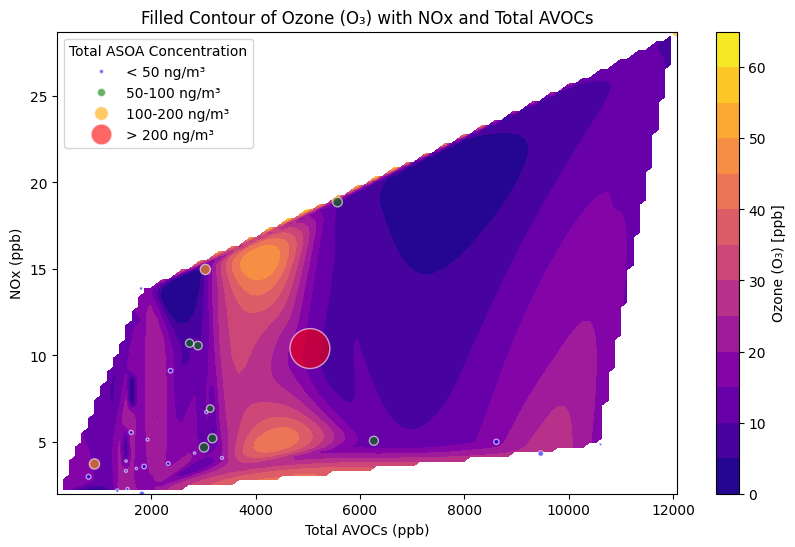

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Sample DataFrame with the provided data
data = {
    'Total_Avocs': [
        1819.89, 6265.61, 796.96, 5567.74, 2892.66, 5039.64, 3035.08,
        12073.42, 3051.44, 3127.92, 1804.30, 2368.14, 8612.50, 190.01,
        1861.31, 10609.55, 1512.88, 1713.21, 1613.41, 1542.90, 1347.72,
        1927.11, 9464.01, 2828.21, 2322.31, 3353.97, 2733.51, 910.09,
        3009.29, 1515.17, 3170.56
    ],
    'NOx_ppb': [
        2.01, 5.07, 2.99, 18.87, 10.57, 10.40, 14.97, 28.71, 6.73,
        6.93, 13.87, 9.12, 5.01, 2.20, 3.58, 4.86, 3.33, 3.47, 5.55,
        2.29, 2.19, 5.14, 4.33, 4.36, 3.75, 4.08, 10.71, 3.73, 4.69,
        3.90, 5.21
    ],
    'O3_ppb': [
        16.27, 11.77, 17.23, 9.43, 10.99, 12.67, 10.28, 8.80, 15.31,
        11.44, 17.61, 17.25, 18.30, 19.75, 17.94, 16.98, 19.49, 17.11,
        22.61, 23.42, 17.77, 21.66, 28.09, 19.85, 18.79, 19.37, 8.09,
        14.07, 10.94, 10.21, 8.09
    ],
    'Total_ASOA': [
        28.95, 84.42, 23.50, 97.58, 75.58, 1651.12, 107.48, 102.66,
        9.97, 58.22, 11.13, 19.74, 28.28, 3.79, 21.21, 7.36,
        8.42, 5.78, 17.50, 9.05, 11.47, 8.11, 31.25, 5.44,
        15.11, 8.43, 70.28, 109.14, 94.01, 5.71, 83.57
    ]
}

df_selected = pd.DataFrame(data)

# Ensure there are no negative O3 values
df_selected = df_selected[df_selected['O3_ppb'] >= 0]

# Create a grid for interpolation
grid_x, grid_y = np.mgrid[
    df_selected['Total_Avocs'].min():df_selected['Total_Avocs'].max():100j,
    df_selected['NOx_ppb'].min():df_selected['NOx_ppb'].max():100j
]

# Perform the interpolation
grid_z = griddata(
    (df_selected['Total_Avocs'], df_selected['NOx_ppb']),
    df_selected['O3_ppb'],
    (grid_x, grid_y),
    method='cubic'
)

# Clip negative values after interpolation
grid_z = np.clip(grid_z, a_min=0, a_max=None)

# Plotting
plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=14, cmap='plasma')
plt.colorbar(contour, label='Ozone (O₃) [ppb]')
plt.xlabel('Total AVOCs (ppb)')
plt.ylabel('NOx (ppb)')
plt.title('Filled Contour of Ozone (O₃) with NOx and Total AVOCs')

# Define colors for different Total_ASOA ranges
def get_color(value):
    if value < 50:
        return 'blue'
    elif 50 <= value < 100:
        return 'green'
    elif 100 <= value < 200:
        return 'orange'
    else:
        return 'red'

# Overlay Total_ASOA as scatter points with colors based on ranges
colors = df_selected['Total_ASOA'].apply(get_color)
scatter = plt.scatter(
    df_selected['Total_Avocs'], df_selected['NOx_ppb'], 
    s=df_selected['Total_ASOA'] * 0.5,  # Scale dot size for visibility
    c=colors, alpha=0.6, edgecolor='w'
)

# Create a legend for Total_ASOA ranges
legend_labels = ['< 50 ng/m³', '50-100 ng/m³', '100-200 ng/m³', '> 200 ng/m³']
legend_colors = ['blue', 'green', 'orange', 'red']
legend_sizes = [30, 60, 100, 150]  # Sizes for the legend markers
handles = []

for size, label, color in zip(legend_sizes, legend_labels, legend_colors):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markersize=size/10, 
                                label=label, markerfacecolor=color, alpha=0.6))

plt.legend(handles=handles, title="Total ASOA Concentration", loc='upper left')
# plt.grid()
plt.show()


In [108]:
# Assuming df_merged already contains 'NOx' and 'O3' columns

# Convert NOx from ng/m³ to ppb
if 'NOx' in df_merged.columns:
    df_merged['NOx_ppb'] = (df_merged['NOx'] * 24.45) / 30.01  # Conversion for NOx

# Convert Ozone from ng/m³ to ppb
if 'O3' in df_merged.columns:
    df_merged['O3_ppb'] = (df_merged['O3'] * 24.45) / 48.00  # Conversion for O3

# Optionally, select relevant columns for final output
df_merged = df_merged[['date', 'NOx_ppb', 'O3_ppb', *df_merged.columns.difference(['NOx', 'O3'])]]

# Print the updated DataFrame
print("Updated DataFrame with NOx and Ozone in ppb:")
print(df_merged.head())


Updated DataFrame with NOx and Ozone in ppb:
         date    NOx_ppb     O3_ppb  1-2-3-trimethylbenzene_amean  \
0  2015-01-13   2.012228  16.274277                     77.462127   
1  2015-01-16   5.072771  11.766002                    110.572030   
2  2015-01-28   2.992937  17.227623                     52.479842   
3  2015-02-03  18.872614   9.427869                    236.873320   
4  2015-02-06  10.573057  10.991141                     71.682292   

   1-2-4-trimethylbenzene_amean  1-3-5-trimethylbenzene_amean  \
0                    147.431332                    201.400943   
1                    176.674299                    185.010542   
2                     71.832151                           NaN   
3                    561.678290                    331.096086   
4                    226.483134                           NaN   

   2-2-4-trimethylpentane_amean  2-METHYL ERYTHRITOL  2-METHYL-4-NITROPHENOL  \
0                     75.137672             0.091915                1

In [109]:
df_merged['O3_ppb']

,O3_ppb,O3_ppb
0,16.274277,16.274277
1,11.766002,11.766002
2,17.227623,17.227623
3,9.427869,9.427869
4,10.991141,10.991141
5,12.674523,12.674523
6,10.283619,10.283619
7,8.803019,8.803019
8,15.313188,15.313188
9,11.443058,11.443058


Converted VOC Data:
   isoprene_amean
0       26.267750
1       27.108598
2       23.154116
3       25.340320
4       24.256376
Merged Data:
          date       NOx       O3  isoprene_amean
0   2015-01-13  2.469814  31.9495       25.340320
1   2015-01-16  6.226334  23.0989       44.100382
2   2015-01-28  3.673539  33.8211       16.727042
4   2015-02-06   12.9774  21.5777       36.629325
5   2015-02-12  12.76544  24.8825       42.138959
6   2015-03-11  18.37467  20.1887       31.192953
7   2015-03-17  35.23643   17.282       41.431315
8   2015-03-24   8.26299  30.0627        8.979588
9   2015-04-02  8.514738  22.4649       52.761946
11  2015-04-17  11.19127  33.8621        0.965726
15  2015-05-21   5.96073  33.3385      120.229569
17  2015-06-02  4.252963  33.5893       64.552130
18  2015-06-04   6.80956  44.3933        7.454406
20  2015-06-19  2.687916  34.8877       23.227378
21  2015-06-23   6.31309  42.5189       37.510134
22  2015-07-02  5.318376  55.1539       70.001822
23  2015-

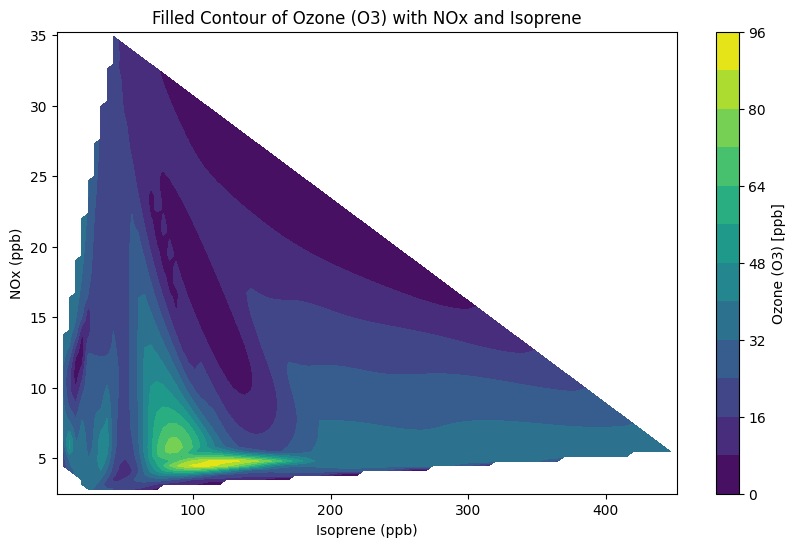

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Define the file path for VOC data
voc_file_path = r'/Users/jayarajupakki/Documents/Phd/Project_PAH/Data/VOC_data.xlsx'

# Load the VOC data from the Excel file
df_voc = pd.read_excel(voc_file_path)

# Define the molecular weights (g/mol)
molecular_weights = {
    "isoprene": 68.10
}

# Define the column to convert
bvoc_column = ['isoprene_amean']

# Check if the column exists in the DataFrame
for col in bvoc_column:
    if col in df_voc.columns:
        # Convert from pmol/mol to ppb
        df_voc[col] = (df_voc[col] * molecular_weights["isoprene"] / 1000) * 24.45
    else:
        print(f"Column '{col}' not found in the DataFrame.")

# Display the converted data to verify
print("Converted VOC Data:")
print(df_voc[bvoc_column].head())

# Load the Excel file with additional data
excel_file_path = r'/Users/jayarajupakki/Documents/Phd/Project_PAH/Data/SIRTA_long term_2015_Max Planck_complete_vf02.xlsx'
df_excel = pd.read_excel(excel_file_path, sheet_name='Database', skiprows=0)

# Process the Excel data
df_excel = df_excel.iloc[1:].reset_index(drop=True)
df_excel['date_column'] = pd.to_datetime(df_excel['Sampling date'], errors='coerce')

# Prepare date filtering
df_excel['date'] = df_excel['date_column'].dt.date

# Ensure the VOC data has a date column; adjust if needed
df_voc['date'] = pd.to_datetime(df_voc['time']).dt.date  # Ensure 'time' is the correct date column

# Merge data based on the 'date' column
df_merged = pd.merge(df_excel, df_voc, on='date', how='inner')

# Calculate NOx (NO + NO2) if those columns exist
if 'NO' in df_merged.columns and 'NO2' in df_merged.columns:
    df_merged['NOx'] = df_merged['NO'] + df_merged['NO2']
else:
    print("NO or NO2 column not found in the merged DataFrame.")

# Define your BVOC columns
bvoc_column = ['isoprene_amean']  # Add other relevant BVOC columns here

# Select relevant columns including BVOC instead of Total_Avocs
df_merged = df_merged[['date', 'NOx', 'O3'] + bvoc_column]  # Add bvoc_column dynamically

# Drop rows with NaN values
df_merged = df_merged.dropna()

# Print the merged data
print("Merged Data:")
print(df_merged)

# Check for negative Ozone values
if (df_merged['O3'] < 0).any():
    print("Negative Ozone values detected. Removing or handling them...")
    df_merged = df_merged[df_merged['O3'] >= 0]  # Remove negatives

# Create grid data for interpolation
grid_x, grid_y = np.mgrid[df_merged['isoprene_amean'].min():df_merged['isoprene_amean'].max():100j,
                           df_merged['NOx'].min():df_merged['NOx'].max():100j]

grid_z = griddata((df_merged['isoprene_amean'], df_merged['NOx']), df_merged['O3'], (grid_x, grid_y), method='cubic')

# Clip negative values after interpolation
grid_z = np.clip(grid_z, a_min=0, a_max=None)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(grid_x, grid_y, grid_z, levels=14, cmap='viridis')
plt.colorbar(label='Ozone (O3) [ppb]')
plt.xlabel('Isoprene (ppb)')
plt.ylabel('NOx (ppb)')
plt.title('Filled Contour of Ozone (O3) with NOx and Isoprene')
plt.show()


In [151]:
import pandas as pd

# Define file paths
excel_file_path = r'/Users/jayarajupakki/Documents/Phd/Project_PAH/Data/SIRTA_long term_2015_Max Planck_complete_vf02.xlsx'
voc_file_path = r'/Users/jayarajupakki/Documents/Phd/Project_PAH/Data/VOC_data.xlsx'

# Load the main Excel data
df_excel = pd.read_excel(excel_file_path, sheet_name='Database', skiprows=0)

# Process the Excel data
# Convert 'Sampling date' to datetime and create a date column
df_excel['date_column'] = pd.to_datetime(df_excel['Sampling date'], errors='coerce')
df_excel['date'] = df_excel['date_column'].dt.date

# Check and calculate NOx
if 'NO' in df_excel.columns and 'NO2' in df_excel.columns:
    df_excel['NOx'] = df_excel['NO'] + df_excel['NO2']
else:
    print("NO or NO2 column not found in the Excel DataFrame.")

# Check for Ozone column and filter DataFrame
if 'O3' in df_excel.columns:
    df_excel = df_excel[['date', 'NOx', 'O3']]
else:
    print("O3 column not found in the Excel DataFrame.")

# Drop rows with NaN values and show the DataFrame
df_excel = df_excel.dropna()
print("DataFrame with date, NOx, and Ozone:")
print(df_excel.head())

# Load the BSOA data
df_bsoa = pd.read_excel(excel_file_path, sheet_name='p+g_SOA_markers', skiprows=[1])

# Define BSOA columns to sum
bsoa_columns = [
    'SUCCINIC ACID', 'ALPHA-METHYLGLYCERIC ACID', 'PINONIC ACID', 
    '3-HYDROXYGLUTARIC ACID', '3-(2-HYDROXY-ETHYL)-2,2-DIMETHYLCYCLOBUT', 
    '3-HYDROX-4,4--DIMETHYLGLUTARIC ACID', '3-ACETYLPENTANEDIOIC ACID', 
    'PINIC ACID', '3-ACETYL HEXANEDIOIC ACID', '3-ISOPROPYLPENTANEDIOIC ACID',
    'TERPENYLIC ACID', '2-METHYLTHREITOL', '2-METHYL ERYTHRITOL', 
    'MBTCA', 'BETA-CARYOPHYLLINIC ACID'
]

# Check for missing BSOA columns
missing_columns = [col for col in bsoa_columns if col not in df_bsoa.columns]
if missing_columns:
    print(f"The following columns are missing from the BSOA DataFrame: {missing_columns}")
else:
    # Calculate Total_BSOA
    df_bsoa['Total_BSOA'] = df_bsoa[bsoa_columns].sum(axis=1)
    print("DataFrame with Total BSOA:")
    print(df_bsoa[[*bsoa_columns, 'Total_BSOA']].head())

# Add date column to BSOA data
df_bsoa['date'] = pd.to_datetime(df_bsoa['Sampling date'], errors='coerce').dt.date

# Merge BSOA and VOC data on 'date'
df_voc = pd.read_excel(voc_file_path)
if 'time' in df_voc.columns:
    df_voc['date'] = pd.to_datetime(df_voc['time'], errors='coerce').dt.date
else:
    print("Date column 'time' not found in VOC data.")

# Merge ASOA and VOC data on 'date'
df_merged = pd.merge(df_bsoa, df_voc, on='date', how='inner')

# Define molecular weights (g/mol)
molecular_weights = {
    "isoprene": 68.10
}

# Define the VOC column to convert
voc_columns = ['isoprene_amean']  # Ensure this contains the correct VOC columns

# Check for VOC columns in merged DataFrame
missing_voc_columns = [col for col in voc_columns if col not in df_merged.columns]
if missing_voc_columns:
    print(f"Column(s) not found in the merged DataFrame: {missing_voc_columns}")
else:
    # Convert VOCs from pmol/mol to ppb
    for col in voc_columns:
        compound_name = col[:-6]  # Remove '_amean'
        if compound_name in molecular_weights:
            df_merged[col] = (df_merged[col] * molecular_weights[compound_name] / 1000) * 24.45

    # Calculate Total AVOCs
    df_merged['Total_Bvocs'] = df_merged[voc_columns].sum(axis=1)
    
    # Print the converted VOCs and Total AVOCs
    print("Converted VOCs to ppb with Total BVOCs:")
    print(df_merged[voc_columns + ['Total_Bvocs']].head())

# Merge the final DataFrame with df_excel on 'date'
df_merged = pd.merge(df_merged, df_excel, on='date', how='inner')

# Convert NOx from ng/m³ to ppb
if 'NOx' in df_merged.columns:
    df_merged['NOx_ppb'] = (df_merged['NOx'] * 24.45) / 30.01  # Conversion for NOx

# Convert Ozone from ng/m³ to ppb
if 'O3' in df_merged.columns:
    df_merged['O3_ppb'] = (df_merged['O3'] * 24.45) / 48.00  # Conversion for O3

# Optionally, select relevant columns for final output
df_merged = df_merged[['date', 'NOx_ppb', 'O3_ppb', 'Total_Bvocs', 'Total_BSOA']]  # Adjust columns as necessary

# Print the updated DataFrame
print("Updated DataFrame with NOx and Ozone in ppb:")
print(df_merged.head())


DataFrame with date, NOx, and Ozone:
          date       NOx       O3
14  2014-12-31  14.63591  26.9422
15  2015-01-02  8.273432  20.0442
16  2015-01-09  1.247024   32.522
17  2015-01-11  1.852793  32.0923
18  2015-01-13  2.469814  31.9495
DataFrame with Total BSOA:
   SUCCINIC ACID  ALPHA-METHYLGLYCERIC ACID  PINONIC ACID  \
0      17.631289                   0.170287      0.933055   
1      14.259354                   0.129743      2.128119   
2      15.544985                   0.284605      0.869196   
3       5.646930                   0.029262      0.759147   
4       8.861779                   0.046652      1.815329   

   3-HYDROXYGLUTARIC ACID  3-(2-HYDROXY-ETHYL)-2,2-DIMETHYLCYCLOBUT  \
0                0.736260                                  0.804116   
1                2.243626                                  1.367456   
2                0.509936                                  1.432389   
3                0.889562                                  0.577849   
4         

/var/folders/d5/7y4f1s550h1gr7jtvhtm9dp80000gn/T/ipykernel_2913/4015312031.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_excel['date_column'] = pd.to_datetime(df_excel['Sampling date'], errors='coerce')


In [152]:
df_merged

,date,NOx_ppb,O3_ppb,Total_Bvocs,Total_BSOA
0,2015-01-13,2.012228,16.274277,25.340320,15.003536
1,2015-01-16,5.072771,11.766002,44.100382,23.147521
2,2015-01-28,2.992937,17.227623,16.727042,14.645542
3,2015-02-03,18.872614,9.427869,0.000000,15.531608
4,2015-02-06,10.573057,10.991141,36.629325,41.157781
5,2015-02-12,10.400367,12.674523,42.138959,74.930182
6,2015-03-11,14.970366,10.283619,31.192953,20.678815
7,2015-03-17,28.708121,8.803019,41.431315,28.783005
8,2015-03-24,6.732093,15.313188,8.979588,17.924572
9,2015-04-02,6.937199,11.443058,52.761946,16.541819


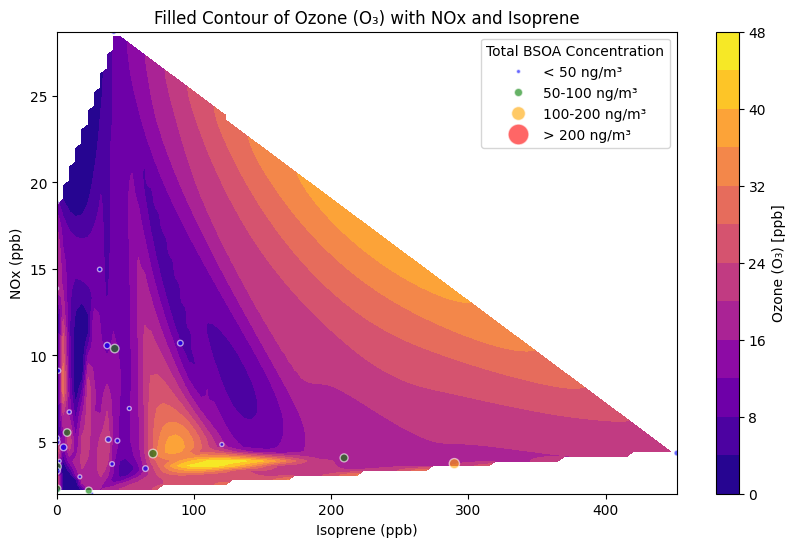

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Sample DataFrame with the provided data
data = {
    'date': ['2015-01-13', '2015-01-16', '2015-01-28', '2015-02-03', '2015-02-06', 
             '2015-02-12', '2015-03-11', '2015-03-17', '2015-03-24', '2015-04-02', 
             '2015-04-14', '2015-04-17', '2015-04-23', '2015-05-05', '2015-05-08', 
             '2015-05-21', '2015-05-27', '2015-06-02', '2015-06-04', '2015-06-12', 
             '2015-06-19', '2015-06-23', '2015-07-02', '2015-07-08', '2015-07-15', 
             '2015-07-22', '2015-11-24', '2015-11-27', '2015-12-03', '2015-12-09', 
             '2015-12-15'],
    'NOx_ppb': [2.012228, 5.072771, 2.992937, 18.872614, 10.573057, 
                10.400367, 14.970366, 28.708121, 6.732093, 6.937199, 
                13.872405, 9.117846, 5.005634, 2.199334, 3.579543, 
                4.856376, 3.333338, 3.46501, 5.547942, 2.294938, 
                2.189922, 5.143454, 4.333032, 4.36147, 3.74916, 
                4.08303, 10.714746, 3.731603, 4.692644, 3.900527, 
                5.210255],
    'O3_ppb': [16.274277, 11.766002, 17.227623, 9.427869, 10.991141, 
                12.674523, 10.283619, 8.803019, 15.313188, 11.443058, 
                17.60563, 17.248507, 18.305766, 19.747195, 17.94085, 
                16.981798, 19.487516, 17.10955, 22.612837, 23.418617, 
                17.770922, 21.658065, 28.094018, 19.850293, 18.787991, 
                19.374689, 8.087194, 14.067104, 10.935619, 10.20925, 
                8.091371],
    'Total_Avocs': [25.340320, 44.100382, 16.727042, 0.000000, 36.629325, 
                    42.138959, 31.192953, 41.431315, 8.979588, 52.761946, 
                    0.000000, 0.965726, 0.000000, 0.000000, 0.000000, 
                    120.229569, 0.000000, 64.552130, 7.454406, 0.000000, 
                    23.227378, 37.510134, 70.001822, 451.901538, 289.671209, 
                    209.311142, 89.965711, 40.210837, 4.860266, 1.823224, 
                    0.000000],
    'Total_ASOA': [15.003536, 23.147521, 14.645542, 15.531608, 41.157781, 
                   74.930182, 20.678815, 28.783005, 17.924572, 16.541819, 
                   11.242051, 25.851650, 38.247450, 22.224439, 76.090917, 
                   16.598339, 46.000452, 33.290273, 58.174511, 65.076872, 
                   52.184963, 33.967450, 75.880749, 34.819971, 108.035259, 
                   65.218260, 32.900656, 21.729594, 46.090673, 12.025851, 
                   28.915388]
}

df_selected = pd.DataFrame(data)

# Ensure there are no negative O3 values
df_selected = df_selected[df_selected['O3_ppb'] >= 0]

# Create a grid for interpolation
grid_x, grid_y = np.mgrid[
    df_selected['Total_Avocs'].min():df_selected['Total_Avocs'].max():100j,
    df_selected['NOx_ppb'].min():df_selected['NOx_ppb'].max():100j
]

# Perform the interpolation
grid_z = griddata(
    (df_selected['Total_Avocs'], df_selected['NOx_ppb']),
    df_selected['O3_ppb'],
    (grid_x, grid_y),
    method='cubic'
)

# Clip negative values after interpolation
grid_z = np.clip(grid_z, a_min=0, a_max=None)

# Plotting
plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=14, cmap='plasma')
plt.colorbar(contour, label='Ozone (O₃) [ppb]')
plt.xlabel('Isoprene (ppb)')
plt.ylabel('NOx (ppb)')
plt.title('Filled Contour of Ozone (O₃) with NOx and Isoprene')

# Define colors for different Total_ASOA ranges
def get_color(value):
    if value < 50:
        return 'blue'
    elif 50 <= value < 100:
        return 'green'
    elif 100 <= value < 200:
        return 'orange'
    else:
        return 'red'

# Overlay Total_ASOA as scatter points with colors based on ranges
colors = df_selected['Total_ASOA'].apply(get_color)
scatter = plt.scatter(
    df_selected['Total_Avocs'], df_selected['NOx_ppb'], 
    s=df_selected['Total_ASOA'] * 0.5,  # Scale dot size for visibility
    c=colors, alpha=0.6, edgecolor='w'
)

# Create a legend for Total_ASOA ranges
legend_labels = ['< 50 ng/m³', '50-100 ng/m³', '100-200 ng/m³', '> 200 ng/m³']
legend_colors = ['blue', 'green', 'orange', 'red']
legend_sizes = [30, 60, 100, 150]  # Sizes for the legend markers
handles = []

for size, label, color in zip(legend_sizes, legend_labels, legend_colors):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markersize=size/10, 
                                label=label, markerfacecolor=color, alpha=0.6))

plt.legend(handles=handles, title="Total BSOA Concentration", loc='upper right')
# plt.grid()
plt.show()
